# Trabajo Práctico 2: Análisis con Random Forest - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [6]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros, que son 'criterio', 'estimadores', 'profundidad' y 'min_samples_leaf' mediante la siguiente función de búsqueda, que utiliza Stratified K-folds cross validation para comparar cada combinación y así obtener la mejor. Nos quedamos con la combinación cuya media de los k-folds(5) tenga la mejor métrica. La métrica de comparación utilizada es AUC-ROC.

In [16]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    for criterio in ['gini', 'entropy']:
        for estimadores in [100,200,300,400,500]:
            for profundidad in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:                
                kf = KFold(n_splits=5)
                metricas_de_la_combinacion = []
                for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
                    random_forest = RandomForestClassifier(n_jobs = -1,max_depth = profundidad, n_estimators = estimadores, criterion = criterio)
                    random_forest.fit(X.iloc[train_index], y.iloc[train_index])
                    y_pred = random_forest.predict_proba(X.iloc[test_index])[:,1]
                    metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
                    print(roc_auc_score(y.iloc[test_index], y_pred))

                print(f"Promedio de la combinacion {np.mean(metricas_de_la_combinacion)}")
                metrics.append((profundidad, estimadores, criterio,np.mean(metricas_de_la_combinacion)))
    df_metrics = pd.DataFrame(metrics, columns = ['profundidad_maxima', 'estimadores', 'criterio','rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]   
    return mejor_combinacion

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [17]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)

0.7182238969457925
0.7552559194335925
0.64785721635129
0.7095151564658564
0.736422600264658
Promedio de la combinacion 0.7134549578922379
0.6376577584968275
0.705238369255742
0.6697539845209619
0.7306409112323224
0.6651041454600977
Promedio de la combinacion 0.6816790337931904
0.7889722774541112
0.6259309423336388
0.6697539845209619
0.8288413393935564
0.6543536237785017
Promedio de la combinacion 0.7135704334961541
0.6996685571679663
0.6906657193485166
0.7925290142535719
0.5
0.732764657980456
Promedio de la combinacion 0.6831255897501021
0.7641651770793583
0.7618435646303241
0.5928998540133072
0.7253423260550034
0.7210587591612378
Promedio de la combinacion 0.7130619361878461
0.7124159870183174
0.7223387667118144
0.7118223595731721
0.7971572025771874
0.5
Promedio de la combinacion 0.6887468631760983
0.5984759474779497
0.7778949964377706
0.7557841519822541
0.5
0.760880496742671
Promedio de la combinacion 0.678607118528129
0.7893545876971675
0.5
0.7409568053434017
0.6706154959020542
0.75

En caso de que dos o más combinaciones den igual, decidimos quedarnos con la combinación que menor profundidad tenga.


In [18]:
mejor_combinacion = mejor_combinacion[mejor_combinacion['profundidad_maxima'] == mejor_combinacion.profundidad_maxima.min()]

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [19]:
parametros_random_forest = mejor_combinacion.loc[:].values[0]
mejor_profundidad = parametros_random_forest[0]
mejor_estimadores = parametros_random_forest[1]
mejor_criterio = parametros_random_forest[2]
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor n° de estimadores: {mejor_estimadores}')
print(f'Mejor criterio: {mejor_criterio}')


Mejor profundidad máxima: 7
Mejor n° de estimadores: 1
Mejor criterio: entropy
Mejor mínima cantidad de instancias por hoja: 0.08


Entrenamos un RandomForest con esa combinación de hiperparámetros.

In [20]:
random_forest = RandomForestClassifier(n_jobs = -1,max_depth = mejor_profundidad, n_estimators = mejor_estimadores, criterion = mejor_criterio)
random_forest.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=0.08,
                       n_estimators=1)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

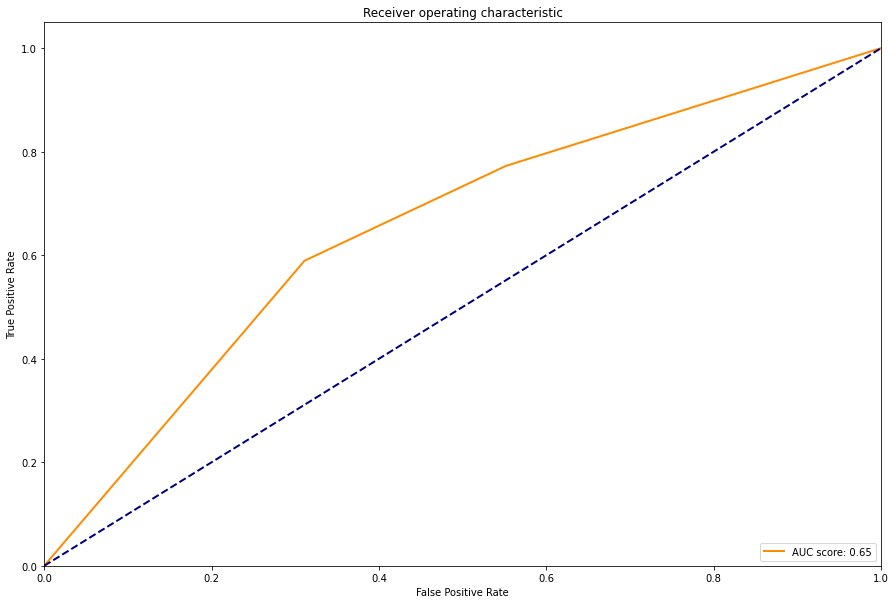

0.6527819624878493

In [21]:
y_pred = random_forest.predict(X_test)
y_pred_proba = random_forest.predict_proba(X_test)[:, 1]
graficar_auc_roc(y_test, y_pred_proba)

Podemos observar que 

Mostramos el classification report:

In [22]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))


                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.76      1.00      0.86      6159
   Tiene Alto Valor Adquisitivo       0.00      0.00      0.00      1982

                       accuracy                           0.76      8141
                      macro avg       0.38      0.50      0.43      8141
                   weighted avg       0.57      0.76      0.65      8141



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Por último, mostramos la matriz de confusión correspondiente:

In [23]:
from funcionesAuxiliares import graficar_matriz_confusion

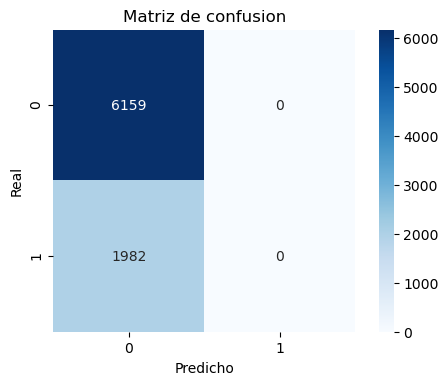

In [24]:
graficar_matriz_confusion(y_test, y_pred)

Podemos ver que

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [16]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [17]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [18]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp, y)
mejor_combinacion = mejor_combinacion[mejor_combinacion['profundidad_maxima'] == mejor_combinacion.profundidad_maxima.min()]

0.5937071437877901
0.6966458282770553
0.6198204999761306
0.8092663461879317
0.710781631718241
Promedio de la combinacion 0.6860442899894298
0.7615405680155607
0.7135132454911048
0.5
0.7643239943425588
0.7224025346091205
Promedio de la combinacion 0.6923560684916689
0.6605471278645265
0.751982191462654
0.5962010420039213
0.7610318048686258
0.7172530282980456
Promedio de la combinacion 0.6974030388995547
0.7882177635024588
0.7882622583751536
0.7778825412637116
0.8163821377544808
0.6230650066164496
Promedio de la combinacion 0.7587619415024508
0.744308540523727
0.6265405663553305
0.5971727907236598
0.6440904604916713
0.8137027305578175
Promedio de la combinacion 0.6851630177304412
0.6605471278645265
0.5
0.6746627431631907
0.5969875872287324
0.658617671009772
Promedio de la combinacion 0.6181630258532443
0.7898428556199798
0.8155336689397082
0.7440183894063325
0.7923167560852685
0.663834486970684
Promedio de la combinacion 0.7611092314043946
0.7311983697709306
0.7666142118600057
0.62567973

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [19]:
parametros_random_forest = mejor_combinacion.loc[:].values[0]
mejor_profundidad = parametros_random_forest[0]
mejor_estimadores = parametros_random_forest[1]
mejor_criterio = parametros_random_forest[2]
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor n° de estimadores: {mejor_estimadores}')
print(f'Mejor criterio: {mejor_criterio}')


Mejor profundidad máxima: 7
Mejor n° de estimadores: 200
Mejor criterio: gini
Mejor mínima cantidad de instancias por hoja: 0.05


Entrenamos un RandomForest con esa combinación de hiperparámetros.

In [20]:
random_forest_expandido = RandomForestClassifier(n_jobs = -1,max_depth = mejor_profundidad, n_estimators = mejor_estimadores, criterion = mejor_criterio)
random_forest_expandido.fit(X_exp_train, y_exp_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=0.05, n_estimators=200)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

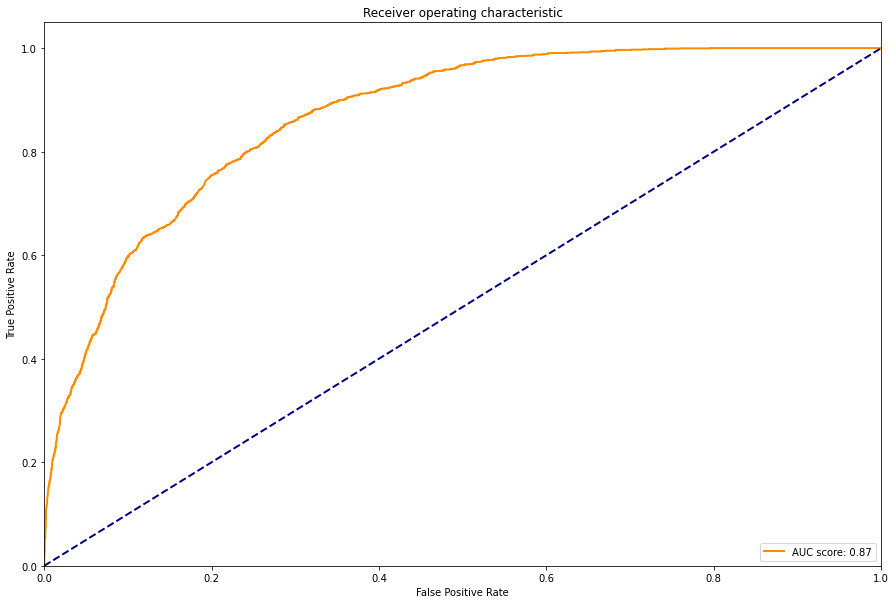

0.8683246228559062

In [21]:
y_pred = random_forest_expandido.predict(X_exp_test)
y_pred_proba = random_forest_expandido.predict_proba(X_exp_test)[:, 1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar que el score de AUC-ROC 

Mostramos el classification report:

In [22]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.80      0.99      0.88      6159
   Tiene Alto Valor Adquisitivo       0.84      0.23      0.36      1982

                       accuracy                           0.80      8141
                      macro avg       0.82      0.61      0.62      8141
                   weighted avg       0.81      0.80      0.76      8141



Por último, mostramos la matriz de confusión correspondiente:

In [23]:
from funcionesAuxiliares import graficar_matriz_confusion

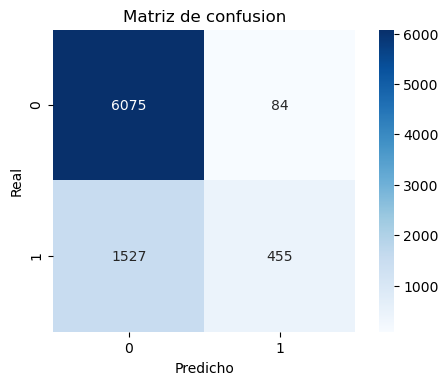

In [24]:
graficar_matriz_confusion(y_exp_test, y_pred)

Podemos ver que el random forest clasifica 

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con el random forest sin expandir el dataset sobre el dataset de holdout, y la escribimos al archivo 'RandomForest.csv'

In [25]:
from funcionesAuxiliares import traer_holdout
from preprocessing import preparar_holdout
from funcionesAuxiliares import escribir_predicciones

In [26]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = aplicar_one_hot_encoding(holdout)

In [27]:
predicciones = random_forest.predict(holdout)
escribir_predicciones(ids, predicciones, "RandomForest")